In [1]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch

In [2]:
# Order and names in the pseudocode
# x=(22.5,0) y=(0,-45) z=(0,0) a=(45,0)
# Channels: 1 2 3 4 13 14 23 24

## Matching the datafile name with the respective input and measurement basis
MBasisList=['x','y','z'] #in order: D L H

BasesO=['DD','DL','DH','LD','LL','LH', 'HD','HL', 'HH']

In [4]:
### RUN IF WE WANT THE PLOT FIDELITY VS POWER ####
working_dir=r"C:\Users\LauraMartins\Documents\PhD\Lab\Code\Tomographies"
os.chdir(working_dir+'\FidvsPower\Pulsed')

folders = [i for i in glob.glob("StateTomography*")]

for iteracao in range(len(folders)):
    os.chdir(working_dir+'\FidvsPower\Pulsed\\'+folders[iteracao])
    info=open('info.txt')
    for line in info:
        fields = line.split()
        #print(fields)
        
powers=np.array([875,803,732,650,565,485,408,330,252,174,98])
powers2=np.array([889,823,742,661,580,500,420,340,260,179,100])

In [5]:
#working_dir=r"C:\Users\LauraMartins\Documents\PhD\Lab\Code\Tomographies"
os.chdir(working_dir+'\Estabilidade')

folders = [i for i in glob.glob("StateTomography*")]

for iteracao in range(len(folders)):
    os.chdir(working_dir+'\Estabilidade\\'+folders[iteracao]+'\\StateTomo')
    
    filenames = [i for i in glob.glob("Bigiteration_0_*")]

    mbasis_number=6

    qubit_number=2
    numberofchannels=8
    counts=np.zeros((numberofchannels,3**qubit_number), dtype=int)
    counts_aux=np.zeros((2**qubit_number,3**qubit_number), dtype=float)
    heralding_single=np.zeros((3**qubit_number), dtype=int)
    sigma_counts=np.zeros((2**qubit_number,3**qubit_number), dtype=float)
    xp_counts=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
    dirinv=np.zeros((len(folders), 2**qubit_number, 2**qubit_number), dtype=complex)
    efficiencies=np.zeros(8, dtype=float)
    expectations=np.zeros(3, dtype=float)


    qubit_number=2

    Pauli=np.asarray([
        [[1,0],
        [0,1]],


        [[0,1],
        [1,0]],


        [[0,-1j],
        [1j,0]],


        [[1,0],
        [0,-1]]])

    def FindingFile(containing, filenames):
        for file in filenames:
             if fnmatch.fnmatch(file, 'Bigiteration_0_'+containing+'_*'):
                return file
        print('No file containing: Bigiteration_0_', containing, '...')
        pass

    ### State tomography ###
    ##Calculating the efficiencies of each detector
    eff=np.array(['zz', 'za', 'az', 'aa'])
    for w in range(4):
        file=FindingFile(eff[w], filenames)
        with open(file) as file: 
            for line in file:
                fields = line.split()
                for iter in range (len(fields)-7):
                    efficiencies[iter]+=float(fields[iter])
        #print('Base, counts', w, fields)

        ######## Simulated counts using Simon's tomography functions ##########
        ### data is saved as "Bigiteration_0_xy" with x(y) being the measurement(input) basis
        ## H is channels 2 and 3
    bases=np.array(['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'])#, ## order: D, L, H
    
for iteracao in range(len(folders)):
    os.chdir(working_dir+'\Estabilidade\\'+folders[iteracao]+'\\StateTomo')
    filenames = [i for i in glob.glob("Bigiteration_0_*")]
    
    for w in range(3**qubit_number):
        file=FindingFile(bases[w], filenames)
        with open(file) as file: 
            for line in file:
                fields = line.split()
                for iter in range (len(fields)-7):
                    # In counts[a][b][c][d], 'a' corresponds to the channel (in order): 1 2 3 4 13 14 23 24 (defined in pseudo)
                    counts[iter][w]=fields[iter]

        counts_aux[0][w]=counts[-2][w]
        counts_aux[1][w]=counts[-1][w]
        counts_aux[2][w]=counts[-4][w]
        counts_aux[3][w]=counts[-3][w]

    ### Normalizing the counts with the detectors efficiencies ###
    efficiencies=efficiencies/np.max(efficiencies)
    print(efficiencies)
    aux=0
    for w in range(3**qubit_number):
        #heralding_single[w]=heralding_single[w]/efficiencies[3]
        counts_aux[0][w]=counts_aux[0][w]/float(efficiencies[-2])#*heralding_single[w]*1e-6)
        counts_aux[1][w]=counts_aux[1][w]/float(efficiencies[-1])#*heralding_single[w]*1e-6)
        counts_aux[2][w]=counts_aux[2][w]/float(efficiencies[-4])#*heralding_single[w]*1e-6)
        counts_aux[3][w]=counts_aux[3][w]/float(efficiencies[-3])#*heralding_single[w]*1e-6)

        if w==0: ## XX expectation value
            expectations[0]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        if w==4: ## YY expectation value
            expectations[1]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        if w==8: ## ZZ expectation value
            expectations[2]=(counts_aux[1][w]+counts_aux[2][w]-counts_aux[0][w]-counts_aux[3][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        if (aux<(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])):
            aux=(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

    for w in range(3**qubit_number):
        print('Output: ', BasesO[w], 'Sum of counts normalized: ', (counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])/aux)

    xp_counts[:][:]=np.array(np.transpose(counts_aux[:][:])) # get the experimental counts
    ### Here we are turning real numbers into integers, I don't know if that is ok

    statetomo=LRETomography(int(qubit_number), xp_counts[:][:], working_dir)
    statetomo.run() ### Runs fast maximum likelihood estimation
    statetomo.quantum_state.get_density_matrix()
    dirinv[iteracao]=statetomo.quantum_state.get_density_matrix()
    print('Fast maximum likelihood estimation: \n', dirinv[iteracao], '\n')

[0.78018815 0.83549277 0.97672449 1.         0.10124171 0.10403539
 0.10810884 0.11152305]
Output:  DD Sum of counts normalized:  1.0
Output:  DL Sum of counts normalized:  0.994513686263207
Output:  DH Sum of counts normalized:  0.9952982802490369
Output:  LD Sum of counts normalized:  0.9917253220952585
Output:  LL Sum of counts normalized:  0.998737711591075
Output:  LH Sum of counts normalized:  0.9934273465185378
Output:  HD Sum of counts normalized:  0.990661153057391
Output:  HL Sum of counts normalized:  0.9934188406137919
Output:  HH Sum of counts normalized:  0.9978347572003662
Fast maximum likelihood estimation: 
 [[ 5.13601145e-03+4.20445691e-19j  4.00495611e-03+4.28133239e-03j
   5.80186877e-03-9.93282382e-04j  1.13732440e-04+1.80209211e-03j]
 [ 4.00495611e-03-4.28133239e-03j  4.99959755e-01+2.80265670e-17j
   4.93858647e-01+6.02135223e-03j  1.36106453e-03-7.90758092e-03j]
 [ 5.80186877e-03+9.93282382e-04j  4.93858647e-01-6.02135223e-03j
   4.94097038e-01-2.74877619e-17j -

In [6]:
folders

['StateTomography202205241843AfterChannel',
 'StateTomography202205242247AfterChannel',
 'StateTomography202205251816AfterChannel',
 'StateTomography202205261141AfterChannel',
 'StateTomography202205261508AfterChannel',
 'StateTomography202205261814AfterChannel',
 'StateTomography202205262046AfterChannel',
 'StateTomography202205271336AfterChannel',
 'StateTomography202205271614AfterChannel',
 'StateTomography202205271855AfterChannel',
 'StateTomography202205280818AfterChannel']

In [7]:
tempo=np.array([0, 4.07, 23.4, 40.9, 44.4, 47.2, 49.7, 56.5, 59.2, 61.8, 75.3])

In [8]:
### Fidelity with expectation values
print("Fidelity is: ", (1+np.sum(np.abs(expectations)))/4)

Fidelity is:  0.9936851108539182


In [8]:
def fidelity(ideal, real):
    return (ideal@real@np.transpose(np.conjugate(ideal)))

#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
#bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

fidelity_plot=np.zeros(len(tempo))
for i in range(len(folders)):
    fidelity_plot[i]=np.real(fidelity(bell, dirinv[i]))
print(fidelity_plot)

[0.99088704 0.99084448 0.00316296 0.98991173 0.99234381 0.99191421
 0.99136746 0.99137673 0.99222029 0.99195134 0.99161353]


(0.988, 0.995)

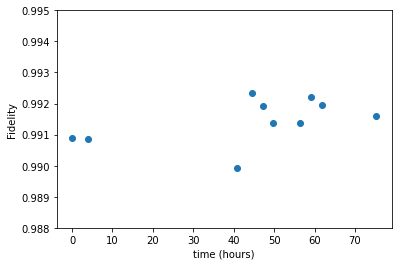

In [9]:
plt.errorbar(tempo, fidelity_plot, fmt='o')
plt.xlabel("time (hours)")
plt.ylabel("Fidelity")
plt.ylim((0.988,0.995))
#plt.savefig('PF.png')

In [14]:
#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

def ApplyUnitaryToBell(U, dm):
    return U@dm@np.transpose(np.conjugate(U))

def GeneralUnitary(x):
    return np.array([[np.exp(1j*x[0])*np.cos(x[2]), np.exp(1j*x[1])*np.sin(x[2])],[-np.exp(-1j*x[1])*np.sin(x[2]), np.exp(-1j*x[0])*np.cos(x[2])]])

def fUnitary(x, *args):
    U1=GeneralUnitary(x[:3])
    U2=GeneralUnitary(x[3:])
    return -np.abs(fidelity(bell, ApplyUnitaryToBell(np.kron(U1,U2), dirinv)))

monitor = VerboseMonitor(50)
npop = 50
result_w=diffev2(fUnitary, x0=np.array([0, 0.4, 0, 0, 0.3, 1.5]), args=dirinv, strategy=Best1Bin, bounds=[(-np.pi,np.pi)]*6, npop=npop, gtol=100, disp=True, ftol=1e-20, itermon=monitor, handler=False)
print('\n The parameters are: ', result_w)
#print('\n The closest unitary to our process matrix is: \n', GeneralUnitary(result_w))
print('\n with a fidelity of: ', -fUnitary(result_w, bellmatrix))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [135]:
Unit1=GeneralUnitary(result_w[:3])
Unit2=GeneralUnitary(result_w[3:])
print('Unitaries: \n U1=', Unit1, '\n U2=', Unit2)
Optimized_matrix=ApplyUnitaryToBell(np.kron(Unit1,Unit2), dirinv)
print('\n State after unitaries: \n', Optimized_matrix)

Unitaries: 
 U1= [[ 0.93755127+0.25304569j  0.20156509+0.12781632j]
 [-0.20156509+0.12781632j  0.93755127-0.25304569j]] 
 U2= [[ 0.73910397+0.63613187j  0.18719392+0.11840605j]
 [-0.18719392+0.11840605j  0.73910397-0.63613187j]]

 State after unitaries: 
 [[ 4.94063586e-01+0.00000000e+00j -9.68156924e-04-1.69672726e-03j
  -1.21436453e-03+2.37097056e-03j  4.95858766e-01+2.84823255e-09j]
 [-9.68156924e-04+1.69672726e-03j  7.30117283e-04+5.36680075e-18j
  -2.16124986e-05+9.30050476e-04j -2.81807682e-03+6.30625725e-04j]
 [-1.21436453e-03-2.37097056e-03j -2.16124986e-05-9.30050476e-04j
   1.23492046e-03+5.20417043e-18j -2.57185010e-03+4.36393805e-05j]
 [ 4.95858766e-01-2.84823255e-09j -2.81807682e-03-6.30625725e-04j
  -2.57185010e-03-4.36393805e-05j  5.03971377e-01-4.85722573e-17j]]


In [205]:
def WP_rotation(t, n):
    R=np.exp(-1j*n/2)*np.array([[np.cos(t)**2+np.exp(1j*n)*np.sin(t)**2,(1-np.exp(1j*n))*np.cos(t)*np.sin(t)],
                                    (1-np.exp(1j*n))*np.cos(t)*np.sin(t),np.sin(t)**2+np.exp(1j*n)*np.cos(t)**2])
    return(R)

In [ ]:
### HWP angles of photon 1
HWP1=np.transpose(np.array([[np.pi/8,np.pi/8,np.pi/8,0,0,0,0,0,0],
[np.pi/8,np.pi/8,np.pi/8,0,0,0,0,0,0],
[-np.pi/8,-np.pi/8,-np.pi/8,0,0,0,0,0,0],
[-np.pi/8,-np.pi/8,-np.pi/8,0,0,0,0,0,0]]))

### QWP angles of photon 1
QWP1=np.transpose(np.array([[np.pi/2,np.pi/2,np.pi/2,3*np.pi/4,3*np.pi/4,3*np.pi/4,np.pi/2,np.pi/2,np.pi/2],
[np.pi/2,np.pi/2,np.pi/2,3*np.pi/4,3*np.pi/4,3*np.pi/4,np.pi/2,np.pi/2,np.pi/2],
[np.pi/2,np.pi/2,np.pi/2,-3*np.pi/4,-3*np.pi/4,-3*np.pi/4,np.pi/2,np.pi/2,np.pi/2],
[np.pi/2,np.pi/2,np.pi/2,-3*np.pi/4,-3*np.pi/4,-3*np.pi/4,np.pi/2,np.pi/2,np.pi/2]]))

### HWP angles of photon 2
HWP2=np.transpose(np.array([[np.pi/8,0,0,np.pi/8,0,0,np.pi/8,0,0],
[-np.pi/8,0,0,-np.pi/8,0,0,-np.pi/8,0,0],
[np.pi/8,0,0,np.pi/8,0,0,np.pi/8,0,0],
[-np.pi/8,0,0,-np.pi/8,0,0,-np.pi/8,0,0]]))

### QWP angles of photon 2
QWP2=np.transpose(np.array([[np.pi/2,3*np.pi/4,np.pi/2,np.pi/2,3*np.pi/4,np.pi/2,np.pi/2,3*np.pi/4,np.pi/2],
[np.pi/2,-3*np.pi/4,np.pi/2,np.pi/2,-3*np.pi/4,np.pi/2,np.pi/2,-3*np.pi/4,np.pi/2],
[np.pi/2,3*np.pi/4,np.pi/2,np.pi/2,3*np.pi/4,np.pi/2,np.pi/2,3*np.pi/4,np.pi/2],
[np.pi/2,-3*np.pi/4,np.pi/2,np.pi/2,-3*np.pi/4,np.pi/2,np.pi/2,-3*np.pi/4,np.pi/2]]))

In [ ]:
r1=WP_rotation(QWP1[][],np.pi/2)@WP_rotation(HWP1[][],np.pi)
r2=WP_rotation(QWP2[][],np.pi/2)@WP_rotation(HWP2[][],np.pi)

MB_change=np.kron(r1,r2)
sim_rho_i=MB_change@Optimized_matrix@np.transpose(np.conjugate(MB_change))



In [206]:
np.array([0,1])@np.array([[0.5,0.5],[0.5,0.5]])@np.transpose(np.array([0,1]))

0.5

In [11]:
### ERRORS ####
### Calculating the errors for the poissonian noise ###
def ApplyUnitaryToBell(U, dm):
    return U@dm@np.transpose(np.conjugate(U))

error_runs=8000
xp_counts_err=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
dm_err=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)
fidelity_err=np.zeros((error_runs), dtype=float)


for i in range(error_runs):
    xp_counts_err=np.random.poisson(lam=xp_counts)
    statetomo_err=LRETomography(int(qubit_number), xp_counts_err, working_dir)
    statetomo_err.run() ### Runs fast maximum likelihood estimation
    statetomo_err.quantum_state.get_density_matrix()
    dm_err[i]=statetomo_err.quantum_state.get_density_matrix()
    
    fidelity_err[i]=round(fidelity(bell, ApplyUnitaryToBell(np.kron(Unit1,Unit2), dm_err[i])), 5)

NameError: name 'Unit1' is not defined

In [ ]:
HWP_dict={"d": np.pi/8,
          "l": 0,
          "v": 0,
          "a": -np.pi/8,
          "r": 0,
          "h": np.pi/4}

QWP_dict={"d": np.pi/2,
          "l": 3*np.pi/4,
          "v": np.pi/2,
          "a": np.pi/2,
          "r": np.pi/4,
          "h": np.pi/2}

projector_dict={"d": 0,
                "l": 1,
                "v": 2,
                "a": 3,
                "r": 4,
                "h": 5}

bases=np.array([['dd', 'dl', 'dv', 'ld', 'll', 'lv', 'vd', 'vl', 'vv'],
               ['da', 'dr', 'dh', 'la', 'lr', 'lh', 'va', 'vr', 'vh'],
               ['ad', 'al', 'av', 'rd', 'rl', 'rv', 'hd', 'hl', 'hv'],
               ['aa', 'ar', 'ah', 'ra', 'rr', 'rh', 'ha', 'hr', 'hh']])

In [ ]:
### ERRORS ####
### Calculating the errors for the poissonian noise
error_runs=8000
xp_counts_err=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
dm_err=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)
fidelity_err=np.zeros((error_runs), dtype=float)


for i in range(error_runs):
    xp_counts_err=np.random.poisson(lam=xp_counts)
    statetomo_err=LRETomography(int(qubit_number), xp_counts_err, working_dir)
    statetomo_err.run() ### Runs fast maximum likelihood estimation
    statetomo_err.quantum_state.get_density_matrix()
    dm_err[i]=statetomo_err.quantum_state.get_density_matrix()
    
    fidelity_err[i]=round(fidelity(bell, ApplyUnitaryToBell(np.kron(Unit1,Unit2), dm_err[i])), 5)

In [ ]:
### Calculating the fidelity of the several run of simulated data
# Define the Gaussian function
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_err)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((len(errorbar_x)), dtype=int)

for i in range(len(error_x)):
    errorbar_y[i]=counted[errorbar_x[i]]

In [193]:
mu, std = norm.fit(fidelity_err)

944.1425940836268 0.9948771424604329 3.295243973484837e-05


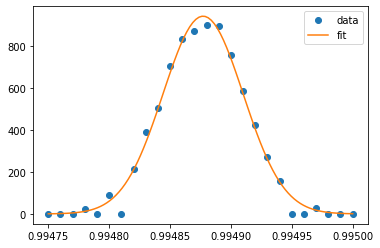

In [194]:
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

parameters, covariance = curve_fit(Gauss, errorbar_x, errorbar_y, bounds=[(800,0.99485,1e-10),(1200,0.9949,0.1)])
  
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata=x = np.linspace(0.99475, 0.995, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x, errorbar_y, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

-1.0